In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

C:\Users\Brian\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1 - Introduction

When planning a concert season, modern professional orchestras have to strike balance between choosing artistically and culturally rich repertoire and choosing pieces of music that will attract an audience and allow the musicians to earn a living. This has unfortunately created a strong bias in programming the famous works of deceased white male composers, because the celebrated masterworks of those composers will surely draw crowds. Programs remain relatively non-diverse to this day, despite continued calls for programming new music.

Can concerts be planned to include more "adventurous" programming choices while still earning the orchestra the necessary revenue to pay its musicians? Here, we will analyze the [archival program records](https://archives.nyphil.org/index.php/open-data) from the New York Philharmonic with the goal of determining how "adventurous" each concert is. From the records, we can extract details about every work performed on a concert program. By tracking the composers represented on each concert, we can determine whether or not a concert is adventurous.

This dataset will allow us to analyze changes in programming over time, across different venues, and between different conductors. Ultimately, we hope to bring in [ticket sales information](https://archives.nyphil.org/index.php/open-data) and analyze the relationship between ticket sales and program content.

# 2 - Load dataset

## 2.1 - Create dataframes from JSON

The raw program data is available for download from the NY Philharmonic's official GitHub repository. The data is stored in `.json` format with a nested structure described at https://github.com/nyphilarchive/PerformanceHistory. The outermost key is `'programs'`.

In [2]:
url = 'https://raw.githubusercontent.com/nyphilarchive/PerformanceHistory/master/Programs/json/complete.json'

r = requests.get(url)
programs = r.json()['programs']

Each program consists of a list of works that is performed at multiple concerts. Using `pd.json_normalize`, we can load the details for each work and concert into separate data frames. Additionally, each work has soloists listed, which can be separated into a third dataframe.

In [3]:
meta_cols = ['id', 'programID', 'orchestra', 'season']
df_concerts = pd.json_normalize(data=programs, record_path='concerts',
    meta=meta_cols)
df_works = pd.json_normalize(data=programs, record_path='works',
    meta=meta_cols)
df_soloists = pd.json_normalize(data=programs, record_path=['works', 'soloists'],
    meta=meta_cols)

In [4]:
df_works.head()

,ID,composerName,workTitle,conductorName,soloists,movement,interval,movement._,movement.em,workTitle._,workTitle.em,id,programID,orchestra,season
0,52446*,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67","Hill, Ureli Corelli",[],NaN,NaN,NaN,NaN,NaN,NaN,00646b9f-fec7-4ffb-9fb1-faae410bd9dc-0.1,3853,New York Philharmonic,1842-43
1,8834*4,"Weber, Carl Maria Von",OBERON,"Timm, Henry C.","[{'soloistName': 'Otto, Antoinette', 'soloistI...","""Ozean, du Ungeheuer"" (Ocean, thou mighty mons...",NaN,NaN,NaN,NaN,NaN,00646b9f-fec7-4ffb-9fb1-faae410bd9dc-0.1,3853,New York Philharmonic,1842-43
2,3642*,"Hummel, Johann","QUINTET, PIANO, D MINOR, OP. 74",NaN,"[{'soloistName': 'Scharfenberg, William', 'sol...",NaN,NaN,NaN,NaN,NaN,NaN,00646b9f-fec7-4ffb-9fb1-faae410bd9dc-0.1,3853,New York Philharmonic,1842-43
3,0*,NaN,NaN,NaN,[],NaN,Intermission,NaN,NaN,NaN,NaN,00646b9f-fec7-4ffb-9fb1-faae410bd9dc-0.1,3853,New York Philharmonic,1842-43
4,8834*3,"Weber, Carl Maria Von",OBERON,"Etienne, Denis G.",[],Overture,NaN,NaN,NaN,NaN,NaN,00646b9f-fec7-4ffb-9fb1-faae410bd9dc-0.1,3853,New York Philharmonic,1842-43


In [5]:
df_soloists.head()

,soloistName,soloistInstrument,soloistRoles,id,programID,orchestra,season
0,"Otto, Antoinette",Soprano,S,00646b9f-fec7-4ffb-9fb1-faae410bd9dc-0.1,3853,New York Philharmonic,1842-43
1,"Scharfenberg, William",Piano,A,00646b9f-fec7-4ffb-9fb1-faae410bd9dc-0.1,3853,New York Philharmonic,1842-43
2,"Hill, Ureli Corelli",Violin,A,00646b9f-fec7-4ffb-9fb1-faae410bd9dc-0.1,3853,New York Philharmonic,1842-43
3,"Derwort, G. H.",Viola,A,00646b9f-fec7-4ffb-9fb1-faae410bd9dc-0.1,3853,New York Philharmonic,1842-43
4,"Boucher, Alfred",Cello,A,00646b9f-fec7-4ffb-9fb1-faae410bd9dc-0.1,3853,New York Philharmonic,1842-43


We first outer merge the concert and works datasets to construct a single `DataFrame`.

In [6]:
df = pd.merge(df_works, df_concerts, 'outer', on=meta_cols)

In [7]:
df.head()

,ID,composerName,workTitle,conductorName,soloists,movement,interval,movement._,movement.em,workTitle._,workTitle.em,id,programID,orchestra,season,eventType,Location,Venue,Date,Time
0,52446*,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67","Hill, Ureli Corelli",[],NaN,NaN,NaN,NaN,NaN,NaN,00646b9f-fec7-4ffb-9fb1-faae410bd9dc-0.1,3853,New York Philharmonic,1842-43,Subscription Season,"Manhattan, NY",Apollo Rooms,1842-12-07T05:00:00Z,8:00PM
1,8834*4,"Weber, Carl Maria Von",OBERON,"Timm, Henry C.","[{'soloistName': 'Otto, Antoinette', 'soloistI...","""Ozean, du Ungeheuer"" (Ocean, thou mighty mons...",NaN,NaN,NaN,NaN,NaN,00646b9f-fec7-4ffb-9fb1-faae410bd9dc-0.1,3853,New York Philharmonic,1842-43,Subscription Season,"Manhattan, NY",Apollo Rooms,1842-12-07T05:00:00Z,8:00PM
2,3642*,"Hummel, Johann","QUINTET, PIANO, D MINOR, OP. 74",NaN,"[{'soloistName': 'Scharfenberg, William', 'sol...",NaN,NaN,NaN,NaN,NaN,NaN,00646b9f-fec7-4ffb-9fb1-faae410bd9dc-0.1,3853,New York Philharmonic,1842-43,Subscription Season,"Manhattan, NY",Apollo Rooms,1842-12-07T05:00:00Z,8:00PM
3,0*,NaN,NaN,NaN,[],NaN,Intermission,NaN,NaN,NaN,NaN,00646b9f-fec7-4ffb-9fb1-faae410bd9dc-0.1,3853,New York Philharmonic,1842-43,Subscription Season,"Manhattan, NY",Apollo Rooms,1842-12-07T05:00:00Z,8:00PM
4,8834*3,"Weber, Carl Maria Von",OBERON,"Etienne, Denis G.",[],Overture,NaN,NaN,NaN,NaN,NaN,00646b9f-fec7-4ffb-9fb1-faae410bd9dc-0.1,3853,New York Philharmonic,1842-43,Subscription Season,"Manhattan, NY",Apollo Rooms,1842-12-07T05:00:00Z,8:00PM


## 2.2 - Soloists (ignore for now)

At some point it might be useful to replace the `soloists` column of the merged dataframe with meaningful information from `df_soloists`. However, for now we will just drop the column.

In [8]:
df = df.drop(columns='soloists')

# 3 - Selecting a relevant subset of the data
The dataset contains information about all sorts of New York Philharmonic-affiliated events, including lectures and chamber music performances. We will limit our focus to large orchestra works and performances.

## 3.1 - Orchestra and event type

Let's examine the possible values for the `orchestra` and `eventType` columns:

In [9]:
df['orchestra'].value_counts()

New York Philharmonic                       92815
Stadium-NY Philharmonic                     13430
New York Symphony                            9411
Musicians from the New York Philharmonic     3223
Members of NY Philharmonic                   1694
NYP Presentation                             1198
NY Philharmonic Ensembles                    1141
New/National Symphony Orchestra               490
Strike Orchestra (Philharmonic)                39
Shanghai Orchestra Academy                     20
Members of NY Symphony                         11
None                                            3
Name: orchestra, dtype: int64

In [10]:
df['eventType'].value_counts().head(10) 
# and there are many more categories - 60 total

Subscription Season       65375
Stadium Concert           13504
Tour                      12877
Young People's Concert     6072
Promenade                  3479
Special                    2718
Parks                      2562
Chamber                    2220
Student Concert            2075
Runout                     1595
Name: eventType, dtype: int64

The definitions for these categories are available at https://archives.nyphil.org/index.php/help-performancehistory. These help us identify which values most likely represent a full orchestra performance. It is clear to keep values like "New York Philharmonic" and "Subscription Season," but others are ambiguous. For example, the description of "Members of NY Philharmonic" explains that these concerts are "offered to" all members of the orchestra, while the concerts from "Musicians of the NY Philharmonic" are more likely to be chamber performances. What kind of concerts correspond to each group?

In [11]:
df['eventType'][df['orchestra'] == 'Members of NY Philharmonic'].value_counts().head()

Carnegie Pop Concert    688
Special                 602
Festival                131
Student Concert          74
Subscription Season      56
Name: eventType, dtype: int64

In [12]:
df['eventType'][df['orchestra'] == 'Musicians from the New York Philharmonic'].value_counts().head()

Chamber                        657
Holiday Brass                  485
Very Young People's Concert    458
Chamber Concert (Private)      424
Tour - Chamber                 246
Name: eventType, dtype: int64

It is clear that we should keep "Members of NY Philharmonic", but not "Musicians from the New York Philharmonic". We arrive at the final listing of orchestra types to keep:

In [13]:
orch_types = ['New York Philharmonic', 'New York Symphony', 
            'Stadium-NY Philharmonic', 'Members of NY Philharmonic',
            'New/National Symphony Orchestra', 'Strike Orchestra (Philharmonic)']
df = df[df['orchestra'].isin(orch_types)]

Likewise, we start from the full list of event types and discard small events based on the descriptions available from the NY Philharmonic.

In [14]:
event_types = df['eventType'].unique()
event_types = [event for event in event_types if 'Chamber' not in event]
other_small_events = ['Contact!', 'Holiday Brass', 'Insight Series', 
                      'Leinsdorf Lecture', 'Nightcap', 'Off the Grid',
                      'Pre-Concert Recital', 'Sound ON', 
                      'Tour - Very Young People\'s Concert',
                      'Very Young People\'s Concert']
event_types = [event for event in event_types if event not in other_small_events]
df = df[df['eventType'].isin(event_types)]

# 4 - Clean columns

## 4.1 - Check missing values

Check the proportion of missing values in each column:

In [15]:
df.isna().sum() / len(df)

ID               0.000025
composerName     0.152055
workTitle        0.152080
conductorName    0.170726
movement         0.713601
interval         0.847971
movement._       0.998810
movement.em      0.997272
workTitle._      0.999975
workTitle.em     0.999975
id               0.000000
programID        0.000000
orchestra        0.000000
season           0.000000
eventType        0.000000
Location         0.000000
Venue            0.000000
Date             0.000000
Time             0.000000
dtype: float64

There are a significant number of columns with missing values. Not every work is split into movements, so having missing values in the movement column is expected. The interval column, as we see below, appears to only indicate that a program has an intermission, and is not of much use. We can drop the column to greatly reduce the number of missing values in the `composerName`, `workTitle`, and `conductorName` columns.

In [16]:
df.interval.value_counts(normalize=True)

Intermission           0.994857
Intermission-Short     0.003019
Intermission-Second    0.002068
Intermission-Third     0.000056
Name: interval, dtype: float64

In [17]:
df = df[df.interval.isna()].drop(columns='interval')
df.isna().sum() / len(df)

ID               0.000030
composerName     0.000030
workTitle        0.000060
conductorName    0.022049
movement         0.662254
movement._       0.998597
movement.em      0.996783
workTitle._      0.999970
workTitle.em     0.999970
id               0.000000
programID        0.000000
orchestra        0.000000
season           0.000000
eventType        0.000000
Location         0.000000
Venue            0.000000
Date             0.000000
Time             0.000000
dtype: float64

## 4.2 - `'.em'` and `'._`' columns

We notice a few strangely named columns with many missing values (e.g. `'movement.em'`). Can we move this information into the `'movement'` and `'workTitle'` columns? Upon examining some representative rows with information in these columns, I figured out that the `'.em'` column contains italicized text in the title of the work (see for example ID 8897*, where [Carmen is italicized in the program](https://archives.nyphil.org/index.php/artifact/7fa203d8-1167-4ec9-b2b0-11a45b02a4a7-0.1) (click "Show all")). This probably came from an `<em>` HTML tag.

In [18]:
cols = ['movement._', 'movement.em', 'workTitle._', 'workTitle.em']
df[df[cols].notna().any(axis=1)].sample(5, random_state=3)

,ID,composerName,workTitle,conductorName,movement,movement._,movement.em,workTitle._,workTitle.em,id,programID,orchestra,season,eventType,Location,Venue,Date,Time
15531,8867*2,"Sibelius, Jean","LEMMINKAINEN SUITE (LEGENDS), OP. 22","Stransky, Josef",NaN,NaN,The Swan of Tuonela,NaN,NaN,934e8e20-953f-4a30-aa1e-c65c24f80b61-0.1,7013,New York Philharmonic,1918-19,Runout,"Wilkes-Barre, PA",Irem Temple,1919-02-03T05:00:00Z,8:30PM
82859,8867*4,"Sibelius, Jean","LEMMINKAINEN SUITE (LEGENDS), OP. 22","Jarvi (Järvi), Neeme",NaN,NaN,Lemminkäinen's Return,NaN,NaN,14e4f1ac-ddfb-451f-b74e-456002ce84a5-0.1,5777,New York Philharmonic,1979-80,Subscription Season,"Manhattan, NY",Avery Fisher Hall,1980-02-21T05:00:00Z,8:00PM
37861,8867*4,"Sibelius, Jean","LEMMINKAINEN SUITE (LEGENDS), OP. 22","Barbirolli , John",NaN,NaN,Lemminkäinen's Return,NaN,NaN,d78eb0cf-f5d4-4ef4-aa39-ee67360f1f7c-0.1,4936,New York Philharmonic,1938-39,Runout,"Princeton, NJ",McCarter Theatre,1938-10-29T05:00:00Z,8:30PM
108570,5696*1,"Williams, John",HARRY POTTER: SUITE,"Williams, John",NaN,Hedwig's Theme (from ),Harry Potter and the Sorcerer's Stone,NaN,NaN,e938cda9-a161-4d18-9034-c2a13eb64cde-0.1,9746,New York Philharmonic,2007-08,Subscription Season,"Manhattan, NY",Avery Fisher Hall,2007-09-14T04:00:00Z,8:00PM
47208,8867*2,"Sibelius, Jean","LEMMINKAINEN SUITE (LEGENDS), OP. 22","Stokowski, Leopold",NaN,NaN,The Swan of Tuonela,NaN,NaN,73c4d118-6bd8-4771-b97d-a36e9956b740-0.1,6408,New York Philharmonic,1946-47,Subscription Season,"Manhattan, NY",Carnegie Hall,1946-12-27T05:00:00Z,2:30PM


It won't be feasible to reconstruct the exact work title, but let's concatenate the strings in the two columns and impute it into the non-suffixed columns.
 
Is the `'movement'` column always empty when the other two have values present (and likewise for '`workTitle'`)? If so, the following code should print four `0`s.

In [19]:
for col in ['movement', 'workTitle']:
    for suffix in ['.em', '._']:
        print(df[df[col+suffix].notna()][col].notna().sum())

0
0
0
0


It is safe to consolidate these columns. Let's do that and drop the `.em` and `._` suffixed columns.

In [20]:
for col in ['movement', 'workTitle']:
    rows = df[col].isna()
    df[col][rows] = df[col+'._'][rows] + ' ' +  df[col+'.em'][rows]
    df.drop(columns=[col+'._', col+'.em'], inplace=True)

In [21]:
df.isna().sum()

ID                   3
composerName         3
workTitle            3
conductorName     2200
movement         65939
id                   0
programID            0
orchestra            0
season               0
eventType            0
Location             0
Venue                0
Date                 0
Time                 0
dtype: int64

## 4.3 - Remaining missing values
Many works are not comprised of multiple movements, so we can keep the missing values in the movement column.

There are many instances where a conductor is not listed. Since most large-ensemble works are performed with a conductor, let's check the rows associated with these missing values.

In [22]:
df[df['conductorName'].isna()].sample(5, random_state=0)

,ID,composerName,workTitle,conductorName,movement,id,programID,orchestra,season,eventType,Location,Venue,Date,Time
97957,8761*3,"Bach, Johann Sebastian","PARTITA NO. 2, D MINOR, BWV 1004",NaN,Sarabande,ea5bfd58-8319-4563-9b07-2fc5388d7062-0.1,8015,New York Philharmonic,1996-97,Subscription Season,"Manhattan, NY",Avery Fisher Hall,1997-01-15T05:00:00Z,8:00PM
100240,8113*3,"Bach, Johann Sebastian","SONATA, VIOLIN, UNACCOMPANIED, NO. 2, A MINOR,...",NaN,Andante,b9a40b38-97a7-4aa3-8fb1-ed62ff9bb1ea-0.1,7996,New York Philharmonic,1998-99,Subscription Season,"Manhattan, NY",Avery Fisher Hall,1999-03-20T05:00:00Z,8:00PM
96695,3152*17,"Gabrieli, Giovanni","SACRAE SYMPHONIAE, BOOK 1",NaN,"Sonata pian' e forte a 8, C. 175 (arr. Fracken...",56290366-ef46-4af4-a24c-f04f9251b5d2-0.1,7808,New York Philharmonic,1995-96,Subscription Season,"Manhattan, NY",Avery Fisher Hall,1995-11-09T05:00:00Z,8:00PM
6416,10359*,"Tchaikovsky, Pyotr Ilyich","HUMORESQUE (SOLO PIANO), OP. 10, NO. 2",NaN,NaN,8a73c52f-95a8-411c-b6e8-3d7bc4d7b90a-0.1,10525,New York Symphony,1904-05,Special,"Manhattan, NY",Carnegie Hall,1905-01-18T05:00:00Z,8:15PM
32935,11706*,"Traditional,",DANCE OF THE COCONUT GROVE (ARR. Hairston),NaN,NaN,963ccf25-b762-4265-b276-26f8616ff660-0.1,13124,Stadium-NY Philharmonic,1932-33,Stadium Concert,"Manhattan, NY",Lewisohn Stadium,1933-08-18T04:00:00Z,8:30PM


It looks like these rows represent smaller ensemble works performed without a conductor. Although possible that some rows will represent orchestral works, with the conductor information missing, we will not lose much by dropping these rows.

In [23]:
df = df[df['conductorName'].notna()]

After this operation, we are left with only missing movement information (as expected).

In [24]:
df.isna().sum()

ID                   0
composerName         0
workTitle            0
conductorName        0
movement         64576
id                   0
programID            0
orchestra            0
season               0
eventType            0
Location             0
Venue                0
Date                 0
Time                 0
dtype: int64

## 4.4 - Date and Time
It may be useful to know the date and time of a performance, but the time zone doesn't really matter. Let's create a single DateTime column with `datetime` objects, throwing away the time zone and placing performances with no indicated time at midnight. We then drop the original date and time columns.

In [25]:
df['Date'].sample()

54338    1953-10-23T05:00:00Z
Name: Date, dtype: object

In [26]:
# check that all dates split into two parts on the 'T'
(df['Date'].str.split('T').str.len() == 2).all()

True

In [27]:
df['DateTime'] = pd.to_datetime(df['Date'].str.split('T').str[0] \
                                 + ' ' + df['Time'].str.replace('None', ''))
df.drop(columns=['Date', 'Time'], inplace=True)
df['DateTime'].sample(5)

83128    1980-05-10 14:00:00
37194    1938-03-11 14:30:00
75290    1972-09-01 19:00:00
22554    1925-02-21 11:00:00
103261   2002-10-26 20:30:00
Name: DateTime, dtype: datetime64[ns]

### Which seasons should we consider?

Below we plot the number of programs per season:

Text(0, 0.5, 'Number of programs')

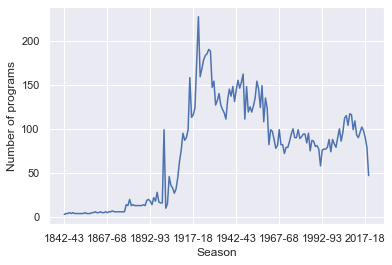

In [28]:
ax = df.groupby(df['season'])['programID'].unique().apply(len).plot()
ax.set_xlabel('Season')
ax.set_ylabel('Number of programs')

The New York Philharmonic and New York National Symphony Orchestra merged in 1921, and this is accompanied by a vast increase in the number of recorded programs. Let's focus on the from the 1922-1923 through 2018-2019 seasons. The 2019-2020 season was not completed due to COVID-19.

In [29]:
season_start_year = df['season'].str.split('-').str[0].astype(int)
df = df[season_start_year >= 1922]
season_start_year = df['season'].str.split('-').str[0].astype(int)
df = df[season_start_year <= 2018]

The number of programs per season is now more uniform

Text(17.200000000000003, 0.5, 'Number of programs')

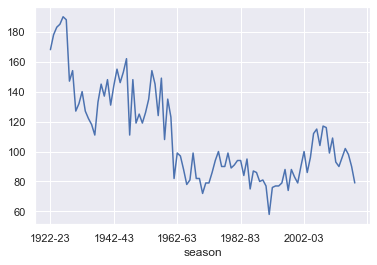

In [30]:
df.groupby(df['season'])['programID'].unique().apply(len).plot()
ax.set_xlabel('Season')
ax.set_ylabel('Number of programs')

## 4.5 - Movements
Some works are separated into multiple rows by movement, but not all multi-movement works are separated in this way. For example, Tchaikovsky's _Symphony No. 4_ (relevant row shown below) is a four-movement work, but is reported as a single row.

In [31]:
df[df['workTitle'].str.lower().str.contains('symphony')].sample(random_state=0)

,ID,composerName,workTitle,conductorName,movement,id,programID,orchestra,season,eventType,Location,Venue,DateTime
86989,2421*,"Mozart, Wolfgang Amadeus","SYMPHONY NO. 28, C MAJOR, K.189K (OLD K.200)","Chung, Myung Whun",NaN,98466fb0-b150-4169-bba3-37b617e2eab7-0.1,5289,New York Philharmonic,1984-85,Subscription Season,"Manhattan, NY",Avery Fisher Hall,1984-10-20 20:00:00


It is unclear which works will have movements reported, so let's represent each work as only a single row.

The column `ID` is in the format (work ID)*(movement ID), so we can use this to group by work. First let's separate this into two columns:

In [32]:
df['work_id'] = df['ID'].str.split('*').str[0]
df['mvt_id'] = df['ID'].str.split('*').str[1]

Now group by `DateTime` and `work_id` (to get a unique performance of the work) and count the number of unique movement IDs.

In [33]:
grouped = df.groupby(['DateTime', 'work_id'])['mvt_id'].nunique()
grouped

DateTime             work_id
1922-10-26 20:30:00  1898       1
                     2599       1
                     52453      1
                     52638      2
1922-10-27 14:30:00  1898       1
                               ..
2019-07-23 18:00:00  8795       1
2019-07-24 18:00:00  2214       1
                     50064      1
                     52625      1
                     5801       1
Name: mvt_id, Length: 70127, dtype: int64

Let's check if this worked:

In [34]:
grouped[grouped>1].sample(random_state=0)

DateTime             work_id
1932-04-10 15:00:00  2889       2
Name: mvt_id, dtype: int64

In [35]:
df[df['DateTime']==pd.to_datetime('1950-03-16 20:45:00')][df['work_id']=='9006']

C:\Users\Brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,ID,composerName,workTitle,conductorName,movement,id,programID,orchestra,season,eventType,Location,Venue,DateTime,work_id,mvt_id
50601,9006*17,"Wagner, Richard",GOTTERDAMMERUNG [GÖTTERDÄMMERUNG],"De Sabata, Victor",PROLOGUE: Siegfried's Rhine Journey,830a1bc8-16ed-434c-a282-43d851cfc5c4-0.1,3801,New York Philharmonic,1949-50,Subscription Season,"Manhattan, NY",Carnegie Hall,1950-03-16 20:45:00,9006,17
50603,9006*21,"Wagner, Richard",GOTTERDAMMERUNG [GÖTTERDÄMMERUNG],"De Sabata, Victor",Siegfried's Death (orchestra without singer - ...,830a1bc8-16ed-434c-a282-43d851cfc5c4-0.1,3801,New York Philharmonic,1949-50,Subscription Season,"Manhattan, NY",Carnegie Hall,1950-03-16 20:45:00,9006,21
50605,9006*10,"Wagner, Richard",GOTTERDAMMERUNG [GÖTTERDÄMMERUNG],"De Sabata, Victor","Siegfried's Funeral Music, ACT III, scene ii",830a1bc8-16ed-434c-a282-43d851cfc5c4-0.1,3801,New York Philharmonic,1949-50,Subscription Season,"Manhattan, NY",Carnegie Hall,1950-03-16 20:45:00,9006,10


_Götterdämmerung_ by Wagner is a [multi-movement opera](https://en.wikipedia.org/wiki/G%C3%B6tterd%C3%A4mmerung), but only 3 movements were performed at the [concert](https://archives.nyphil.org/index.php/artifact/830a1bc8-16ed-434c-a282-43d851cfc5c4-0.1).

Now, we update the dataframe. We drop the `movement` column and drop rows that have the same `DateTime` and `work_id`. The resulting dataframe should be the same length as the `grouped` Series.

In [36]:
df = df.drop(columns=['movement', 'mvt_id'])\
        .drop_duplicates(['DateTime', 'work_id'])

len(df), len(grouped)

(70127, 70127)

We can finally add the grouped series as a new column with the number of movements.

In [37]:
df = df.join(grouped, on=['DateTime', 'work_id'])

## 4.6 - Reorder and rename columns for readability

In [38]:
df = df.rename(columns={'id': 'program_guid', 'programID': 'program_id',
                       'mvt_id': 'num_movements'})

cols = ['program_guid', 'program_id', 'work_id', 'composerName', 'workTitle', 
       'num_movements', 'orchestra', 'conductorName', 'season', 'eventType', 'Location', 
        'Venue', 'DateTime']

df = df[cols]

# convert string ids to numeric
cols = ['program_id', 'work_id']
df[cols] = df[cols].apply(pd.to_numeric)


In [39]:
df.head()

,program_guid,program_id,work_id,composerName,workTitle,num_movements,orchestra,conductorName,season,eventType,Location,Venue,DateTime
19663,6c447a19-4925-4ffe-b29b-b747c6a17535-0.1,4978,52453,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",1,New York Philharmonic,"Stransky, Josef",1922-23,Subscription Season,"Manhattan, NY",Carnegie Hall,1922-10-26 20:30:00
19664,6c447a19-4925-4ffe-b29b-b747c6a17535-0.1,4978,52453,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",1,New York Philharmonic,"Stransky, Josef",1922-23,Subscription Season,"Manhattan, NY",Carnegie Hall,1922-10-27 14:30:00
19667,6c447a19-4925-4ffe-b29b-b747c6a17535-0.1,4978,2599,"Korngold, Erich","SURSUM CORDA, OP. 13",1,New York Philharmonic,"Stransky, Josef",1922-23,Subscription Season,"Manhattan, NY",Carnegie Hall,1922-10-26 20:30:00
19668,6c447a19-4925-4ffe-b29b-b747c6a17535-0.1,4978,2599,"Korngold, Erich","SURSUM CORDA, OP. 13",1,New York Philharmonic,"Stransky, Josef",1922-23,Subscription Season,"Manhattan, NY",Carnegie Hall,1922-10-27 14:30:00
19669,6c447a19-4925-4ffe-b29b-b747c6a17535-0.1,4978,52638,"Debussy, Claude",NOCTURNES,2,New York Philharmonic,"Stransky, Josef",1922-23,Subscription Season,"Manhattan, NY",Carnegie Hall,1922-10-26 20:30:00


# 5 - Analysis

## 5.1 How many times is each composer represented?

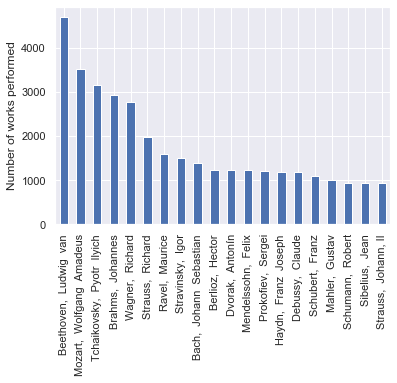

In [40]:
composer_counts = df['composerName'].value_counts()
ax = composer_counts[:20].plot.bar()
ax.set_ylabel('Number of works performed');

Not unexpectedly, we see the works of a few of the most famous composers performed with a much greater frequency than the rest. After the "top 5", the frequency of performance is relatively constant for a large group of composers that are still very well-known.

What about the lesser-known composers? We see from the below that approximately 1/3 of all composers have had works performed only once, and 1/2 of all composers have had works performed at most twice.

In [41]:
composer_counts.value_counts(normalize=True).head()

1    0.329344
2    0.159729
3    0.099376
4    0.087409
5    0.030697
Name: composerName, dtype: float64

The log-scale histogram of the number of composers versus number of performances of works by each composer shows an exponential relationship. However, we can start to see groups forming based on popularity.

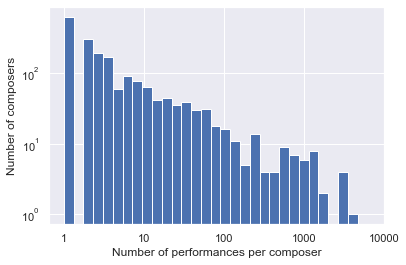

In [42]:
ax = np.log(composer_counts).hist(bins=30, log=True)
ax.set_xlabel('Number of performances per composer')
ax.set_ylabel('Number of composers')
xticks = [1, 10, 100, 1000, 10000]
ax.set_xticks([np.log(tick) for tick in xticks])
ax.set_xticklabels(xticks);

Let's assign a numerical value to each composer that gives some measure of their popularity. We can make this proportional to the log-scaled number of performances each composer was represented in. The column `composer_popularity` contains this defined metric.

In [43]:
# df.drop(columns='composer_popularity', inplace=True)
df.insert(4, 'composer_popularity', \
          np.log(composer_counts[df['composerName']]).values)
df.head()

,program_guid,program_id,work_id,composerName,composer_popularity,workTitle,num_movements,orchestra,conductorName,season,eventType,Location,Venue,DateTime
19663,6c447a19-4925-4ffe-b29b-b747c6a17535-0.1,4978,52453,"Beethoven, Ludwig van",8.454040,"SYMPHONY NO. 7 IN A MAJOR, OP.92",1,New York Philharmonic,"Stransky, Josef",1922-23,Subscription Season,"Manhattan, NY",Carnegie Hall,1922-10-26 20:30:00
19664,6c447a19-4925-4ffe-b29b-b747c6a17535-0.1,4978,52453,"Beethoven, Ludwig van",8.454040,"SYMPHONY NO. 7 IN A MAJOR, OP.92",1,New York Philharmonic,"Stransky, Josef",1922-23,Subscription Season,"Manhattan, NY",Carnegie Hall,1922-10-27 14:30:00
19667,6c447a19-4925-4ffe-b29b-b747c6a17535-0.1,4978,2599,"Korngold, Erich",4.025352,"SURSUM CORDA, OP. 13",1,New York Philharmonic,"Stransky, Josef",1922-23,Subscription Season,"Manhattan, NY",Carnegie Hall,1922-10-26 20:30:00
19668,6c447a19-4925-4ffe-b29b-b747c6a17535-0.1,4978,2599,"Korngold, Erich",4.025352,"SURSUM CORDA, OP. 13",1,New York Philharmonic,"Stransky, Josef",1922-23,Subscription Season,"Manhattan, NY",Carnegie Hall,1922-10-27 14:30:00
19669,6c447a19-4925-4ffe-b29b-b747c6a17535-0.1,4978,52638,"Debussy, Claude",7.067320,NOCTURNES,2,New York Philharmonic,"Stransky, Josef",1922-23,Subscription Season,"Manhattan, NY",Carnegie Hall,1922-10-26 20:30:00


## 5.2 - How adventurous is a each performance?
We are interested in figuring out how lesser-known composers are included in programs. Are their pieces typically performed alongside more famous pieces, or are there full programs of these types of works? More generally, are works from similarly popular composers typically performed together?

Below, we plot a histogram of the standard deviation of the composer popularity for all works from a single performance. We notice a large peak near zero, suggesting that similarly popular composers are indeed performed together.

Text(0, 0.5, 'Number of performances')

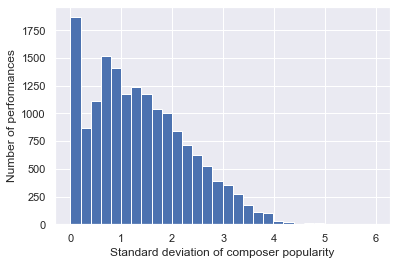

In [44]:
grouped = df.groupby(['program_id', 'DateTime'])['composer_popularity']
ax = grouped.std().hist(bins=30)
ax.set_xlabel('Standard deviation of composer popularity')
ax.set_ylabel('Number of performances')

To get to the heart of our question, let's define a metric using the mean popularity across composers represented in a program. An "adventurous" program (e.g. a program full of works by up-and-coming composers) will have a low value for this metric, while a "safe" program (e.g. and all-Beethoven program) will have a high value. For lack of a better term, we will call this the `safety` (high values for a tried-and-true popular program).

In [45]:
# df.drop(columns='safety', inplace=True)
df.insert(5, 'safety', grouped.transform('mean'))

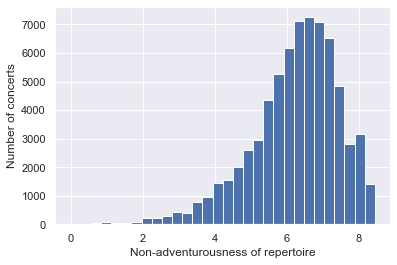

In [46]:
ax = df['safety'].hist(bins=30)
ax.set_xlabel('Non-adventurousness of repertoire')
ax.set_ylabel('Number of concerts');

## 5.3 - Does the level of adventurous programming change while the orchestra is on tour?

Does the popularity of composers represented on a program differ when the orchestra is on tour? We will define "on tour" as performances given outside the NYC boroughs.

We obtain subsets of the data for each group of performances and compare the histograms.

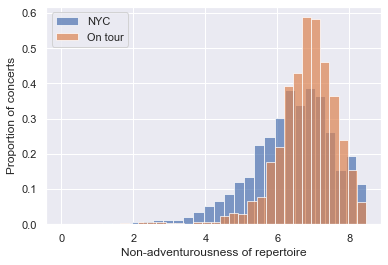

In [47]:
boroughs = ['Manhattan, NY', 'Brooklyn, NY', 'Queens, NY', 'Bronx, NY', 'Staten Island, NY']
df_nyc = df[df['Location'].isin(boroughs)]
df_tour = df.drop(df_nyc.index)

grouped_nyc = df_nyc.groupby(['program_id', 'DateTime'])
grouped_tour = df_tour.groupby(['program_id', 'DateTime'])

safety_nyc = grouped_nyc['composer_popularity'].mean()
safety_tour = grouped_tour['composer_popularity'].mean()

fig, ax = plt.subplots()
ax.hist(safety_nyc, bins=30, alpha=0.7, density=True, label='NYC')
ax.hist(safety_tour, bins=30, alpha=0.7, density=True, label='On tour')
ax.set_xlabel('Non-adventurousness of repertoire')
ax.set_ylabel('Proportion of concerts');
ax.legend(loc='best')
fig.savefig('Adventurousness_on_tour.pdf', bbox_inches='tight')

Although the average program is just as adventurous on tour as for performances in the NYC area, the variation of program content on tour appears to be lower than that in NYC.

Also, there is a marked decrease in the proportion of highly non-adventurous programs (the last bin in the histogram) while on tour. These are likely programs comprised only of works by one composer (e.g. all-Beethoven). As a final check, we will see if there is a difference in the relative frequency of programs with only one composer represented.

In [48]:
def n_composers(x, n):
    return x.nunique() == n

num_composers = np.arange(1, 5)

prop_with_num_nyc = np.zeros(5)
prop_with_num_tour = np.zeros(5)

for i, n in enumerate(num_composers):
    prop_with_num_nyc[i] = grouped_nyc['composerName'].transform(n_composers, n).sum() / len(df_nyc)
    prop_with_num_tour[i] = grouped_tour['composerName'].transform(n_composers, n).sum() / len(df_tour)
    
# "5+" 
prop_with_num_nyc[4] = 1 - prop_with_num_nyc.sum()
prop_with_num_tour[4] = 1 - prop_with_num_tour.sum()

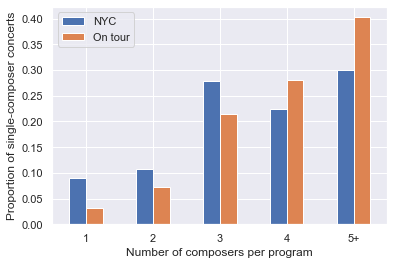

In [49]:
df_one_composer = pd.DataFrame({'NYC': prop_with_num_nyc, 'On tour': prop_with_num_tour})
ax = df_one_composer.plot.bar(rot=0)
ax.set_xticklabels([1, 2, 3, 4, '5+'])
ax.set_xlabel('Number of composers per program')
ax.set_ylabel('Proportion of single-composer concerts')
ax.figure.savefig('Number_of_composers.pdf', bbox_inches='tight')

We see not only that single-composer concerts are far less common on tour, but that approximately half of all on-tour concerts feature 5 or more composers.

## 5.4 Mean program safety per season

Have seasons been getting more adventurous over time? Here we will calculate the `safety` metric per program, and then the average of the mean safety for each program per calendar year.

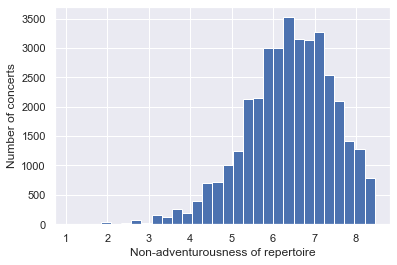

In [50]:
# Select Subscription only
df_sub = df[df['eventType'] == 'Subscription Season']
ax = df_sub['safety'].hist(bins=30)
ax.set_xlabel('Non-adventurousness of repertoire')
ax.set_ylabel('Number of concerts');

In [51]:
safety_per_year = df_sub.groupby(df_sub['DateTime'].dt.year)['safety'].mean()

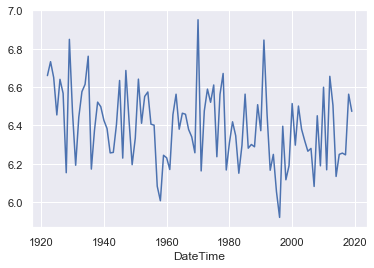

In [52]:
ax = safety_per_year.plot()

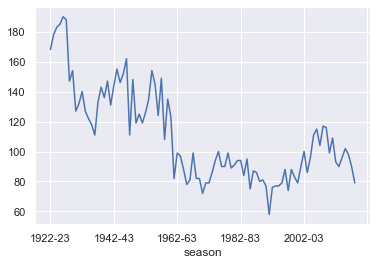

In [53]:
df.groupby(df['season'])['program_id'].unique().apply(len).plot()

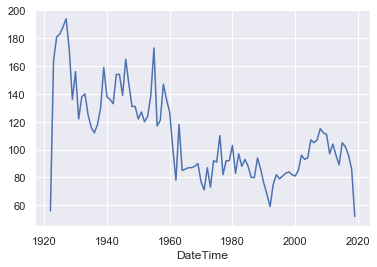

In [54]:
df.groupby(df['DateTime'].dt.year)['program_id'].unique().apply(len).plot()

In [55]:
df_sub.groupby(df_sub['DateTime'].dt.year)['safety'].mean()

DateTime
1922    6.659924
1923    6.732465
1924    6.649629
1925    6.454835
1926    6.640415
          ...   
2015    6.249203
2016    6.255731
2017    6.246588
2018    6.562931
2019    6.473297
Name: safety, Length: 98, dtype: float64

In [56]:
df_1850 = df[df.DateTime.dt.year == 1850]

In [57]:
df_1850

,program_guid,program_id,work_id,composerName,composer_popularity,safety,workTitle,num_movements,orchestra,conductorName,season,eventType,Location,Venue,DateTime


# Future Work

Although the musicians of the New York Philharmonic are undoubtedly in support of adventurous programming, they still need to earn a living. One might expect that "safe" performances with keystone works by famous composers are effective in drawing a larger audience than those featuring lesser-known composers. Moreover, new works outside the [public domain](https://en.wikipedia.org/wiki/Public_domain_music) may pose additional overhead costs for the performance, including rental and licensing fees.

Given information about the ticket sales for each performance, it will be possible to draw conclusions about which types of performances draw larger audiences. We can then determine a balance of "adventurous" and "safe" programs that will most likely bring in enough revenue to secure fair pay for the musicians. A limited datset with information about subscriber ticket sales is available from the New York Philharmonic and a more complete one [may be available upon request](https://archives.nyphil.org/index.php/open-data).